In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import get_from_config
import fur.path_assistant as path_assistant
from touschek.touschek import get_LamTska, get_Touschek_Lifetime_Lebedev,\
                                get_Touschek_Lifetime_Valishev
shift = path_assistant.PathAssistant('shift_03_16_2020')
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel
i_to_photoel = 1/N_to_I
meas_ROUND = pd.read_csv(shift.get_results_dir().fi('meas_ROUND_03_16_2020.csv'), index_col=0)
meas_ROUND = meas_ROUND.sort_values(by='N',ignore_index=True)

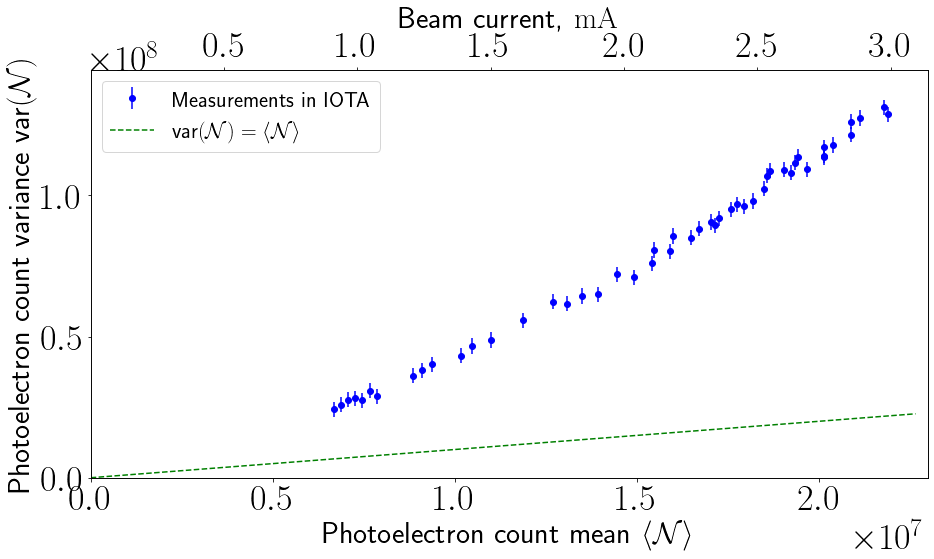

In [2]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})
colors = {"FLAT": 'blue'}

fig, ax = plt.subplots(figsize=(15, 7.5))
ax.errorbar(meas_ROUND['N'],meas_ROUND['varN'],marker='o',linestyle='None',
            yerr=meas_ROUND['errorbar'],color='b',
            label = r'Measurements in IOTA')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_xlim(0, 1.05*meas_ROUND['N'].max())
ax.set_ylim(0, 1.1*meas_ROUND['varN'].max())
ax1 = ax.twiny()
ax1.set_xlabel('Beam current, \SI{}{mA}')
ax1.set_xlim(N_to_I*np.asarray(ax.get_xlim()))
ax1.set_xticks(ticks=ax1.get_xticks()[1:-1])
plt.show()

In [3]:
df = pd.read_csv("M_on_grid_precalc.csv", index_col=0)
df_EB = pd.read_csv("M_on_grid_precalc_EB.csv", index_col=0)
df_ET = pd.read_csv("M_on_grid_precalc_ET.csv", index_col=0)

In [4]:
df.head()

,0.06,0.06857142857142857,0.07714285714285714,0.08571428571428573,0.09428571428571428,0.10285714285714287,0.11142857142857143,0.12
6.693879e+06,2.221984e+06,2.478707e+06,2.738453e+06,3.001321e+06,3.267457e+06,3.536921e+06,3.809616e+06,4.085455e+06
6.868607e+06,2.232259e+06,2.489990e+06,2.750771e+06,3.014674e+06,3.281838e+06,3.552339e+06,3.826136e+06,4.103022e+06
7.057312e+06,2.243369e+06,2.502187e+06,2.764074e+06,3.029091e+06,3.297380e+06,3.569039e+06,3.843973e+06,4.122039e+06
7.249983e+06,2.254729e+06,2.514671e+06,2.777677e+06,3.043832e+06,3.313292e+06,3.586113e+06,3.862211e+06,4.141467e+06
7.445827e+06,2.266292e+06,2.527336e+06,2.791512e+06,3.058828e+06,3.329460e+06,3.603451e+06,3.880718e+06,4.161206e+06


In [5]:
es = df.columns.values.astype(np.float64)

In [6]:
es

array([0.06      , 0.06857143, 0.07714286, 0.08571429, 0.09428571,
       0.10285714, 0.11142857, 0.12      ])

In [7]:
def reconstruct_e(avN, varN, en='0'):
    Mexp = avN**2/(varN-avN)
    df0 = {'0':df, 'B':df_EB, 'T':df_ET}[en]
    return np.interp(Mexp,df0.loc[avN,:],es)

In [8]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0]+0.01e8)

0.06625254563615697

In [9]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0])

0.07079722174946498

In [10]:
meas_ROUND['e_rec'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']]), axis=1)
meas_ROUND['e_rec_EB'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']], en='B'), axis=1)
meas_ROUND['e_rec_ET'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']], en='T'), axis=1)
meas_ROUND['varNtop'] = meas_ROUND['varN']+meas_ROUND['errorbar']
meas_ROUND['varNbottom'] = meas_ROUND['varN']-meas_ROUND['errorbar']
meas_ROUND['e_error_top'] = meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNbottom']]), axis=1)\
        - meas_ROUND['e_rec']
meas_ROUND['e_error_bottom'] = -meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNtop']]), axis=1)\
        + meas_ROUND['e_rec']

# Systematic error of reconstructed e due to beam energy uncertainty

In [11]:
# 1e3*meas_ROUND.loc[:,['e_rec_EB', 'e_rec_ET']].apply(lambda col:col-meas_ROUND.loc[:,'e_rec'],axis=0)

In [12]:
meas_ROUND['I_mA'] = meas_ROUND['N']*N_to_I

In [13]:
# calculation of reconstructed sy
import lattice.lattice as lattice
#from lattice.summary_in_undulator import CalcTransverseBeamParams
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))
from scipy.interpolate import interp1d
bp_df = pd.read_csv(shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
ex_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
# def get_sy(row):
#     Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
#         lattice_df, ex_func(row['N']), row['ey_rec'], dpp_func(row['N']))
#     return np.sqrt(Sy**2+syp**2*dy**2)
# meas_FLAT["sy_rec"] = meas_FLAT.apply(get_sy, axis=1)

In [14]:
# # save new meas_FLAT with ey and I_mA
# meas_FLAT.to_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'))

In [15]:
round_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_round.csv"))

In [16]:
meas_FLAT = pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'), index_col=0)

In [17]:
flat_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_flat.csv"),
                     index_col=0)

In [18]:
from scipy.interpolate import interp1d
bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
sx_r_func = interp1d(bp_df["N"], bp_df['Sigma_um_X'],
                   bounds_error=False, fill_value="extrapolate")
sy_r_func = interp1d(bp_df["N"], bp_df['Sigma_um_Y'],
                   bounds_error=False, fill_value="extrapolate")
sz_r_func = interp1d(bp_df["N"], bp_df['sz_cm_rms'],
                   bounds_error=False, fill_value="extrapolate")
ex_r_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_r_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_r_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
Vrf_r_func = interp1d(bp_df["N"], bp_df['N:IRFEPA'],
                    bounds_error=False, fill_value="extrapolate")


bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_flat.csv"))
sx_f_func = interp1d(bp_df["N"], bp_df['Sigma_um_X'],
                   bounds_error=False, fill_value="extrapolate")
sy_f_func = interp1d(bp_df["N"], bp_df['Sigma_um_Y'],
                   bounds_error=False, fill_value="extrapolate")
sz_f_func = interp1d(bp_df["N"], bp_df['sz_cm_rms'],
                   bounds_error=False, fill_value="extrapolate")
ex_f_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_f_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_f_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
Vrf_f_func = interp1d(bp_df["N"], bp_df['N:IRFEPA'],
                    bounds_error=False, fill_value="extrapolate")

In [19]:
def remove_outliers_omce(df, c1, l1):
    di = df[c1].diff().abs()
    return df[di < l1]
    
def remove_outliers(df, c1, l1, niter):
    for _ in range(niter):
        df = remove_outliers_omce(df, c1, l1)
    return df
round_df = remove_outliers(round_df,'N:IWCMI_recalibrated_to_IWCMI_absolute', 0.1, 10)
round_df = remove_outliers(round_df,'ex_um', 0.01, 10)
round_df = remove_outliers(round_df,'ey_um', 0.01, 10)

flat_df = remove_outliers(flat_df,'N:IWCMI_recalibrated_to_IWCMI_absolute', 0.1, 10)


# Coupled lattice

In [40]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

In [45]:
with open(shift.get_6dsim_dir().fi("twiss4D_nuX0.29_nuY0.29.dat")) as f:
    f.read(1)
    ldf = pd.read_table(f, delim_whitespace=True)
ldf['nu1'] = 2*np.pi*ldf['Teta1/(2*PI)']
ldf['nu2'] = 2*np.pi*ldf['Teta2/(2*PI)']
ldf.head()

,N,NAME,S[cm],BetaX1,AlfaX1,BetaY1,AlfaY1,Teta1/(2*PI),BetaX2,AlfaX2,BetaY2,AlfaY2,Teta2/(2*PI),U,DspX,DspXp,DspY,DspYp,Q1,Q2,M56[cm],nu1,nu2
0,0,START,0.00,41.0619,0.017796,54.9686,0.024039,0.458775,39.2820,-0.017364,52.4795,-0.023431,0.043183,0.505862,-24.5745,0.000023,0.000042,4.994970e-07,0.00000,0.00000,0.000000,2.882568,0.271329
1,1,oLStart,0.00,41.0619,0.017796,54.9686,0.024039,0.458775,39.2820,-0.017364,52.4795,-0.023431,0.043183,0.505862,-24.5745,0.000023,0.000042,4.994970e-07,0.00000,0.00000,0.000000,2.882568,0.271329
2,2,oL1,1.75,41.0178,0.007376,54.8988,0.015874,0.459564,39.3627,-0.028777,52.5758,-0.031592,0.042220,0.505862,-24.5745,0.000023,0.000043,4.994970e-07,0.00335,0.00262,0.000046,2.887526,0.265277
3,2,oL1,3.50,41.0102,-0.003044,54.8575,0.007709,0.460353,39.4834,-0.040191,52.7006,-0.039752,0.041261,0.505862,-24.5744,0.000023,0.000044,4.994970e-07,0.00671,0.00523,0.000091,2.892483,0.259249
4,2,oL1,5.25,41.0391,-0.013464,54.8448,-0.000456,0.461139,39.6441,-0.051605,52.8540,-0.047913,0.040307,0.505862,-24.5744,0.000023,0.000045,4.994970e-07,0.01006,0.00784,0.000137,2.897422,0.253257


In [49]:
N = len(ldf.index)

In [50]:
c1 = np.cos(ldf['nu1'])
c2 = np.cos(ldf['nu2'])
s1 = np.sin(ldf['nu1'])
s2 = np.sin(ldf['nu2'])
e1 = np.exp(1j*ldf['nu1'])
e2 = np.exp(1j*ldf['nu2'])

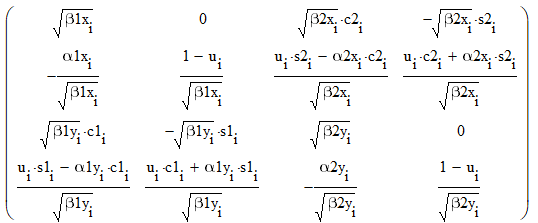

In [66]:
V = np.zeros(shape=(N, 4, 4))
V[:,0,0] = np.sqrt(ldf['BetaX1'])
V[:,0,2] = np.sqrt(ldf['BetaX2'])*c2
V[:,0,3] = -np.sqrt(ldf['BetaX2'])*s2
V[:,1,0] = -ldf['AlfaX1']/np.sqrt(ldf['BetaX1'])
V[:,1,1] = (1-ldf['U'])/np.sqrt(ldf['BetaX1'])
V[:,1,2] = (ldf['U']*s2-ldf['AlfaX2']*c2)/np.sqrt(ldf['BetaX2'])
V[:,1,3] = (ldf['U']*c2+ldf['AlfaX2']*s2)/np.sqrt(ldf['BetaX2'])
V[:,2,0] = np.sqrt(ldf['BetaY1'])*c1
V[:,2,1] = -np.sqrt(ldf['BetaY1'])*s1
V[:,2,2] = np.sqrt(ldf['BetaY2'])
V[:,3,0] = (ldf['U']*s1-ldf['AlfaY1']*c1)/np.sqrt(ldf['BetaY1'])
V[:,3,1] = (ldf['U']*c1+ldf['AlfaY1']*s1)/np.sqrt(ldf['BetaY1'])
V[:,3,2] = -ldf['AlfaY2']/np.sqrt(ldf['BetaY2'])
V[:,3,3] = (1-ldf['U'])/np.sqrt(ldf['BetaY2'])

In [71]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=ldf['BetaX1'],
                    mode='lines+markers',
                    name='BetaX1'))
fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=ldf['BetaX2'],
                    mode='lines+markers',
                    name='BetaX2'))
fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=ldf['BetaY1'],
                    mode='lines+markers',
                    name='BetaY1'))
fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=ldf['BetaY2'],
                    mode='lines+markers',
                    name='BetaY2'))
fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=c1,
                    mode='lines+markers',
                    name='cos nu1'))
fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=c2,
                    mode='lines+markers',
                    name='cos nu2'))

fig.show()

In [76]:
ldf

KeyError: 1400